오늘을 포함한 50거래일의 OHLCV(input data)를 바탕으로 내일의 Open Price를 예측

o : 시가
H : 고가
L : 저가
C : 종가
V : 거래량

1. fdr에서 종목 정보를 가져옴
2. 아래와 같이 모델을 짜서 트레이닝 시킨다
  input, X : 
  t = 0~49 OHLCV (0-1 Minmax scale)

  Model :
  LSTM, 
  dropout = 0.2
  hidden layers 64
  activation = sigmoid
  Optimizer : Adam
  learning rate = 0.0005
  Loss : mse

  Training: 
  batch_size = 32
  epochs 50

  Output, y:
  t= 50's O

  



https://www.youtube.com/watch?v=aIg1Bcm7iB4

In [7]:
!pip install -U finance-datareader
# 패키지 설치 안되신 분은 위에 코드 주석해제하시고 패키지를 설치해주세요
# ref: https://github.com/huseinzol05/Stock-Prediction-Models
# and TGG amended some parameters and built data-pipeline which enables the code use FinanceDataReader data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import FinanceDataReader as fdr # 주가 정보를 가져오는 라이브러리

In [15]:
def call_dataset(ticker = '005930', stt = '2015-01-01', end = '2021-03-30', history_points = 50):
    data = fdr.DataReader(ticker, stt, end)
    data = data.iloc[:,0:-1]
    print('data: ', data.shape)
    data = data.values # 값만 갖고온다
    data_normalizer = preprocessing.MinMaxScaler() # 데이터를 0~1 범위로 점철되게 하는 함수 call
    data_normalized = data_normalizer.fit_transform(data) # 데이터를 0~1 범위로 점철되게 함수 수행
    print('data_normalized: ', data_normalized.shape)
     # using the last {history_points} open close high low volume data points, predict the next open value
    ohlcv_histories_normalized = np.array([data_normalized[i:i + history_points].copy() for i in range(len(data_normalized) - history_points)]) # ohlcv를 가지고 오되, 관찰일수 만큼 누적해서 쌓는다. (열방향으로)
    print('ohlcv_histories_normalized: ', ohlcv_histories_normalized.shape)

    next_day_open_values_normalized = np.array([data_normalized[:, 0][i + history_points].copy() for i in range(len(data_normalized) - history_points)])
    next_day_open_values_normalized = np.expand_dims(next_day_open_values_normalized, -1) # 1XN 벡터 -> NX1 벡터로

    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1) # 1XN 벡터 -> NX1 벡터로

    y_normalizer = preprocessing.MinMaxScaler()
    y_normalizer.fit(next_day_open_values)

    # 인풋 X : 그 이전의 OHLCV (from T = -50 to T = -1)
    # 아웃풋 y : 예측하고자 하는 주가 T = 0

    def calc_ema(values, time_period):
        # https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
        sma = np.mean(values[:, 3])
        ema_values = [sma]
        k = 2 / (1 + time_period)
        for i in range(len(his) - time_period, len(his)):
            close = his[i][3]
            ema_values.append(close * k + ema_values[-1] * (1 - k))
        return ema_values[-1]

    technical_indicators = []
    for his in ohlcv_histories_normalized:
        # note since we are using his[3] we are taking the SMA of the closing price
        # print('his: ', his)
        # print('his[:, 3]: ', his[:, 3])
        sma = np.mean(his[:, 3]) # 각 데이터포인트별 Close Price 평균
        macd = calc_ema(his, 12) - calc_ema(his, 26) # 12일 EMA - 26일 EMA
        technical_indicators.append(np.array([sma]))
        # technical_indicators.append(np.array([sma,macd,]))

    technical_indicators = np.array(technical_indicators)

    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalized = tech_ind_scaler.fit_transform(technical_indicators)

    technical_indicators = np.array(technical_indicators)

    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalized = tech_ind_scaler.fit_transform(technical_indicators)

    assert ohlcv_histories_normalized.shape[0] == next_day_open_values_normalized.shape[0] == technical_indicators_normalized.shape[0]

    print('ohlcv_histories_normalized.shape[0]: ', ohlcv_histories_normalized.shape[0])

    return ohlcv_histories_normalized, technical_indicators_normalized, next_day_open_values_normalized, next_day_open_values, y_normalizer

In [16]:
history_points = 50
ticker = '000660' # sk hynix

import keras
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers
import numpy as np
np.random.seed(4)
# from tensorflow import set_random_seed
import tensorflow
print(tensorflow.__version__)
tensorflow.random.set_seed(44)
# from util import csv_to_dataset, history_points

# dataset

ohlcv_histories, _, next_day_open_values, unscaled_y, y_normaliser = call_dataset(ticker=ticker)

train_ratio = 0.7
n = int(ohlcv_histories.shape[0] * train_ratio)

ohlcv_train = ohlcv_histories[-n:-1]
y_train = next_day_open_values[-n:-1]

ohlcv_test = ohlcv_histories[:ohlcv_histories.shape[0]-n]
y_test = next_day_open_values[:ohlcv_histories.shape[0]-n]

unscaled_y_test = unscaled_y[:ohlcv_histories.shape[0]-n]

print('ohlcv_train.shape: ', ohlcv_train.shape)
print('ohlcv_test.shape: ',ohlcv_test.shape)

2.8.2
data:  (1534, 5)
data_normalized:  (1534, 5)
ohlcv_histories_normalized:  (1484, 50, 5)
ohlcv_histories_normalized.shape[0]:  1484
ohlcv_train.shape:  (1037, 50, 5)
ohlcv_test.shape:  (446, 50, 5)


In [17]:
ohlcv_train 

array([[[0.11845842, 0.12394366, 0.12613784, 0.12464358, 0.21335245],
        [0.12616633, 0.13400402, 0.13567404, 0.13971487, 0.3337236 ],
        [0.13914807, 0.13963783, 0.14694408, 0.14052953, 0.23526744],
        ...,
        [0.15740365, 0.15251509, 0.16428262, 0.15437882, 0.04434815],
        [0.15415822, 0.15895372, 0.16428262, 0.16334012, 0.02775658],
        [0.16592292, 0.1694165 , 0.17815345, 0.17515275, 0.09813116]],

       [[0.12616633, 0.13400402, 0.13567404, 0.13971487, 0.3337236 ],
        [0.13914807, 0.13963783, 0.14694408, 0.14052953, 0.23526744],
        [0.13752535, 0.13440644, 0.14260945, 0.13604888, 0.07244746],
        ...,
        [0.15415822, 0.15895372, 0.16428262, 0.16334012, 0.02775658],
        [0.16592292, 0.1694165 , 0.17815345, 0.17515275, 0.09813116],
        [0.17241379, 0.16820926, 0.17815345, 0.16904277, 0.1023952 ]],

       [[0.13914807, 0.13963783, 0.14694408, 0.14052953, 0.23526744],
        [0.13752535, 0.13440644, 0.14260945, 0.13604888, 0.0

In [20]:
# model architecture
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)

model = Model(inputs=lstm_input, outputs=output)
# adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer='adam', loss='mse',metrics='accuracy')
model.fit(x=ohlcv_train, y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)
# evaluation

y_test_predicted = model.predict(ohlcv_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict(ohlcv_histories)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

from datetime import datetime
model.save(f'basic_model.h5')

Epoch 1/50
30/30 [==============================] - 6s 75ms/step - loss: 0.0310 - accuracy: 0.0000e+00 - val_loss: 0.1335 - val_accuracy: 0.0000e+00
Epoch 2/50
30/30 [==============================] - 1s 40ms/step - loss: 0.0109 - accuracy: 0.0000e+00 - val_loss: 0.1315 - val_accuracy: 0.0000e+00
Epoch 3/50
30/30 [==============================] - 1s 39ms/step - loss: 0.0071 - accuracy: 0.0000e+00 - val_loss: 0.0452 - val_accuracy: 0.0096
Epoch 4/50
30/30 [==============================] - 1s 44ms/step - loss: 0.0026 - accuracy: 0.0000e+00 - val_loss: 0.0196 - val_accuracy: 0.0096
Epoch 5/50
30/30 [==============================] - 1s 42ms/step - loss: 0.0020 - accuracy: 0.0000e+00 - val_loss: 0.0262 - val_accuracy: 0.0096
Epoch 6/50
30/30 [==============================] - 1s 31ms/step - loss: 0.0018 - accuracy: 0.0000e+00 - val_loss: 0.0153 - val_accuracy: 0.0096
Epoch 7/50
30/30 [==============================] - 1s 25ms/step - loss: 0.0016 - accuracy: 0.0000e+00 - val_loss: 0.0084 

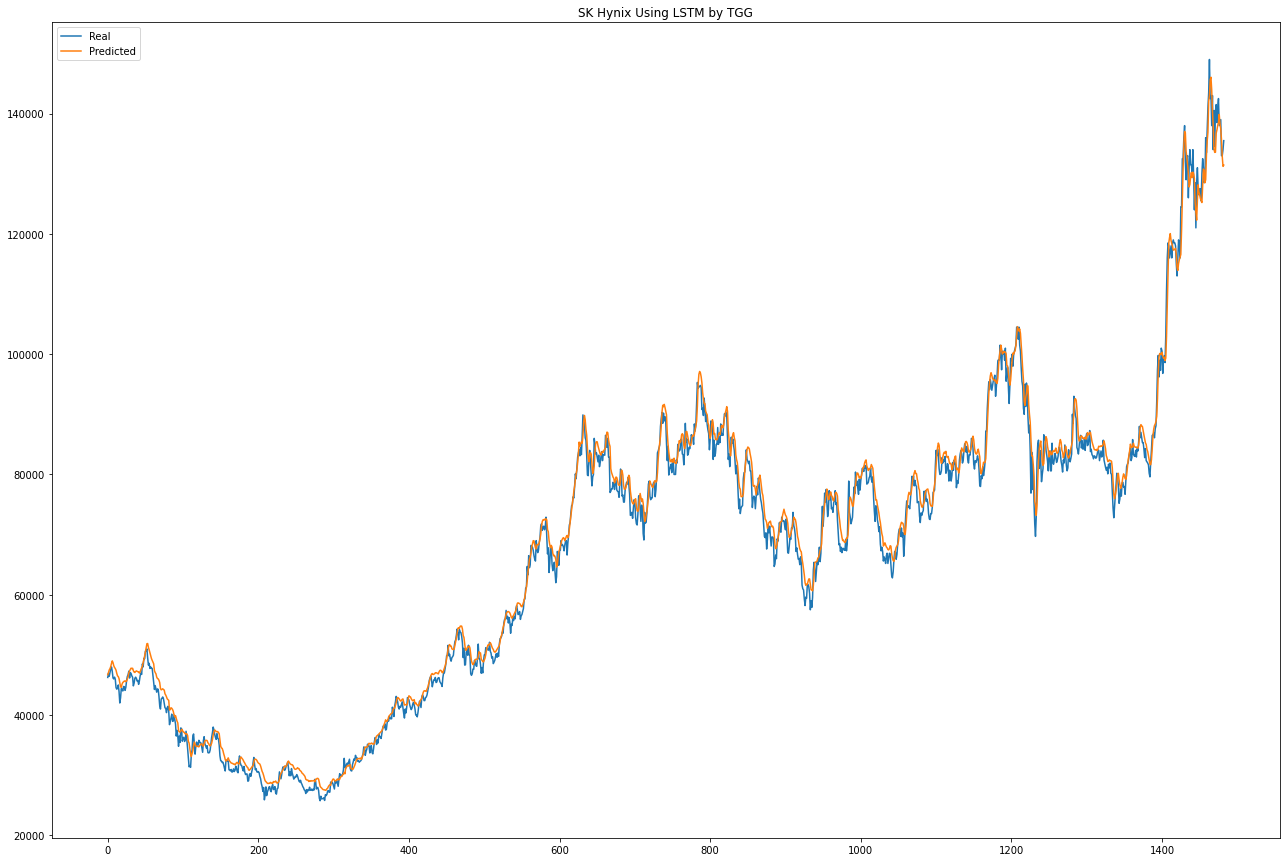

In [21]:
import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

# real = plt.plot(unscaled_y_test[start:end], label='real') 
# pred = plt.plot(y_test_predicted[start:end], label='predicted')

real = plt.plot(unscaled_y[start:end], label='real')
pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])
plt.title('SK Hynix Using LSTM by TGG')
plt.show()

In [22]:
col_name = ['real', 'pred']
real, pred = pd.DataFrame(unscaled_y[start:end]), pd.DataFrame(y_predicted[start:end])
foo = pd.concat([real, pred], axis = 1)
foo.columns = col_name

In [23]:
foo.corr()

,real,pred
real,1.000000,0.997521
pred,0.997521,1.000000


In [24]:
foo['real+1'] = foo['real'].shift(periods = 1)
foo[['real+1', 'pred']].corr()

,real+1,pred
real+1,1.000000,0.998937
pred,0.998937,1.000000
